Ada  
* 2020-06-21 第一版本
* 2020-07-13 代码重构，以及哗啦啦网页变更引起的代码变更
* 2020-07-15 添加供应链数据
* 2020-08-24 增加爬虫失败多次尝试以及校验最终需求文件是否产生，对于目前生产环境未用到的表，都取消爬虫

####  哗啦啦商户中心

* 商户基本档 -> 集团菜谱 -> 门店菜谱 -> 门店菜品管理

#### 哗啦啦报表中心

* 会员营销报表 -> 会员会员卡基础信息表，会员交易明细表
* 运营汇总报表 -> 订单明细查询，收银明细表
* 菜品销售报表 -> 菜品销售明细表

#### 供应链

报表->库存报表

* 库存 -> 库存进出明细表
* 供应商 供应商分店表，供应商进货明细，供应商订货明细
* 其他 库存周转明细，库存周转率

In [1]:
import pandas as pd
import numpy as np
import os
import re
from collections import OrderedDict
import zipfile
import glob
from shutil import copyfile
import datetime
import time
import io
import string
from functools import wraps
from IPython import display

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.chrome.options import Options

from profile_default.startup.private import HUALALA_GROUP_ID
from profile_default.startup.private import HUALALA_USER_ID
from profile_default.startup.private import HUALALA_PASSWORD

SECONDS = {
    'short': 1,
    'middle': 10,
    'long': 60
}

TODAY = datetime.date.today()
PT = TODAY.strftime('%Y%m%d')

hour = datetime.datetime.now().hour

if hour <= 12:
    END_DATE = TODAY - datetime.timedelta(1)
else:
    END_DATE = TODAY

START_DATE = END_DATE.replace(day=1)
MONTH_ID = END_DATE.strftime('%Y%m')

START_TIME = datetime.datetime.combine(START_DATE, datetime.time(0))
END_TIME = datetime.datetime.combine(END_DATE, 
                                     datetime.time(23,59,59))


HOME_DIR = os.getenv('HOME')
BASE_DIR = os.path.join(HOME_DIR, 'Downloads')
os.chdir(BASE_DIR)

print(BASE_DIR)

INPUT_FOLDER = os.path.join(BASE_DIR, '哗啦啦', 'input')
OUPUT_FOLDER = os.path.join(BASE_DIR, '哗啦啦', 'output')
#WAIT_SECONDS = sorted(SECONDS.values())
WAIT_SECONDS = np.arange(0, 4)

def input_path(filename, input_folder=INPUT_FOLDER):
    return os.path.join(input_folder, filename)

def output_path(filename, output_folder=OUPUT_FOLDER):
    return os.path.join(output_folder, filename)


def multiple_trials(wait_seconds=WAIT_SECONDS):
    def _multiple_trials(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            for idx, wait_second in enumerate(wait_seconds):
                msg = ''
                msg += ('wait %s seconds\n' % wait_second)
                msg += ('multiple_trials %s: %s, %s, %s\n' % \
                        (idx + 1, func.__name__, args, kwargs))

                time.sleep(wait_second)
                try:
                    if idx > 0:
                        print(msg)
                    return func(*args, **kwargs)
                except Exception as e:
                    if idx == 0:
                        print(msg)
                    print('ERROR: %s\n' % e)
                    
            time.sleep(wait_second)
            return func(*args, **kwargs)
        return wrapper
    return _multiple_trials

print(START_DATE, END_DATE)
print(START_TIME, END_TIME)
print(PT, MONTH_ID)
print(HUALALA_USER_ID)

/Users/ada/Downloads
2020-09-01 2020-09-14
2020-09-01 00:00:00 2020-09-14 23:59:59
20200914 202009
187******70


In [2]:
# 打开谷歌浏览器

@multiple_trials()
def get_upcoming_events(url, pt=PT):
    driver = webdriver.Chrome()
    driver.get(url)
    return driver

# 等待网页内容加载完毕
@multiple_trials()
def wait_until(condition, driver):
    wait = WebDriverWait(driver, SECONDS['long'])
    wait.until(condition)

# 获取网页元素
@multiple_trials()
def get_elements(driver, name, by='class'):
    if by == 'class':
        wait_until(lambda x: x.find_element_by_class_name(name), driver)
        return driver.find_elements_by_class_name(name)
    elif by == 'css':
        wait_until(lambda x: x.find_element_by_css_selector(name), driver)
        return driver.find_elements_by_css_selector(name)

# 获取网页元素字典
@multiple_trials()
def get_element_map(driver, name, by='class', property_name='text'):
    element_map = OrderedDict()
    elements = get_elements(driver, name, by)
    for element in elements:

        property_val = element.get_attribute(property_name) or element.get_property(property_name)
        if property_val is None and property_name == 'text':
            property_val = element.text
        if type(property_val) == str:
            property_val = property_val.replace(' ', '')
        element_map[property_val] = element_map.get(property_val, element)
    return element_map
    
# 寻找网页元素
@multiple_trials()
def find_element(driver, name, by='class', property_name='text', property_val=None):
    if property_val is None:
        if by == 'class':
            wait_until(lambda x: x.find_element_by_class_name(name), driver)
            return driver.find_element_by_class_name(name)
        elif by == 'css':
            wait_until(lambda x: x.find_element_by_css_selector(name), driver)
            return driver.find_element_by_css_selector(name)
    else:   
        wait_until(lambda x: get_element_map(x, name, by, property_name).get(property_val), driver)
        element_map = get_element_map(driver, name, by, property_name)
        return element_map.get(property_val)

# 获取按钮
@multiple_trials()
def get_button_map(driver, property_name='text'):
    element_map = get_element_map(driver, 'button', 'css', property_name)
    return element_map

In [3]:
# 进入报表中心

@multiple_trials()
def clean_window(driver):
    windows = driver.window_handles
    while True:
        window = windows.pop()
        print(window)
        driver.switch_to.window(window)
        if len(windows) > 0:
            driver.close()
            time.sleep(SECONDS['short'])
        else:
            break
            
@multiple_trials()    
def report_center(driver):
    driver.switch_to.window(driver.window_handles[0])
    report = find_element(driver, 'ant-menu-item', property_val='报表中心')
    report.click()
    time.sleep(SECONDS['short'])

    next_window = driver.window_handles[1]
    driver.switch_to.window(next_window)
    
    print('title:', driver.title)
    return get_element_map(driver, 'ant-menu-submenu-title')

# 进入下载清单
@multiple_trials()
def get_download_items(driver):
    download_menu = find_element(driver, 'menu-dowload')
    download_menu.click()
    time.sleep(SECONDS['short'])
    find_element(driver, 'button', 'css', '刷 新').click()
    time.sleep(SECONDS['short'])
    while 'dowload-center__doing' in driver.page_source:
        find_element(driver, 'button', 'css', '刷 新').click()
        time.sleep(SECONDS['short'])
        
    table_title = driver.find_element_by_class_name('dowload-center__table-title')
    table_content = driver.find_element_by_class_name('dowload-center__table-content')
    columns = [x.text for x in table_title.find_elements_by_css_selector('span')]
    
    items = table_content.find_elements_by_class_name('dowload-center__table-item')
    if len(items) == 0:
        return None
    item_text = [x.text.split('\n') for x in items]
    download_df = pd.DataFrame(item_text, columns=columns)

    buttons = table_content.find_elements_by_class_name('dowload-center__btn')
    download_buttons = [
        x.find_element_by_class_name('dowload-center__btn-dowload') for x in buttons
    ]

    delete_buttons = [
        x.find_element_by_class_name('dowload-center__btn-delete') for x in buttons    
    ]

    download_df['download'] = download_buttons
    download_df['delete'] = delete_buttons
    
    return download_df

# 下载清单操作，点击下载或者删除
@multiple_trials()
def download_list_action(driver, action=None):
    download_df = get_download_items(driver)
    is_empty = download_df is None
    
    if action in ['download', 'delete'] and not is_empty:
        for button in download_df[action]:
            try:
                button.click()
                time.sleep(SECONDS['short'])
            except:
                continue
    return is_empty 

# 按主题找报表
@multiple_trials()
def report_domain(driver, report_map, subject, report):
    current_report = report_map[subject]
    ActionChains(driver).move_to_element(current_report).perform()
    time.sleep(SECONDS['short'])
    
    current_base = find_element(driver, 'ant-menu-item', property_val=report)       
    current_base.click()
    time.sleep(SECONDS['short'])

    button_map = get_button_map(driver)
    return button_map

# 获取选择日期元素

def get_date_map(driver):
    day_map = {}
    for x in driver.find_elements_by_class_name('ant-calendar-cell'):
        day = re.sub('[^0-9]', '-', x.get_attribute('title'))
        day = pd.Timestamp(day).date()
        day_map[day] = x
    
    min_date = min(day_map.keys())
    max_date = max(day_map.keys())
    print('date map date range', min_date, max_date)
    return day_map, min_date, max_date

# 选择日期范围
@multiple_trials()
def choose_date_range(driver, start_date=START_DATE, end_date=END_DATE):
    calendar_pickers = driver.find_elements_by_class_name('ant-calendar-picker')
    calendar_picker = calendar_pickers[0]
    if len(calendar_pickers) > 1:
        calendar_picker2 = calendar_pickers[1]
    else:
        calendar_picker2 = calendar_pickers[0]
    for picker in calendar_pickers:
        try:
            picker.click()
            break
        except:
            continue
            
    time.sleep(SECONDS['short'])
    for _ in range(12):
        date_map, min_date, max_date = get_date_map(driver)
        prev_month_btn = driver.find_element_by_class_name('ant-calendar-prev-month-btn')
        next_month_btn = driver.find_element_by_class_name('ant-calendar-next-month-btn')
        if start_date >= min_date and end_date <= max_date:
            break
        elif start_date < min_date:
            prev_month_btn.click()
        else:
            next_month_btn.click()
            
        time.sleep(SECONDS['short'])
    date_map[start_date].click()
    
    try:
        time.sleep(SECONDS['short'])
        date_map, min_date, max_date = get_date_map(driver)
        date_map[end_date].click()
    except:
        print('exception 1')
        calendar_picker2.click()
        time.sleep(SECONDS['short'])
        date_map, min_date, max_date = get_date_map(driver)
        date_map[END_DATE].click()
    
@multiple_trials()
def element_clear(element, n=20):
    for _ in range(n):
        element.send_keys(Keys.BACKSPACE)
        
# 选择日期时间范围    
@multiple_trials()
def choose_datetime_range(driver):

    calendar = driver.find_element_by_class_name('ant-calendar-picker-input')
    start_element = calendar.find_element_by_css_selector('input')
    start_element.click()  
    start_element, end_element = driver.find_elements_by_class_name('ant-calendar-input')    

    element_clear(start_element)
    start_element.send_keys(str(START_TIME))    

    element_clear(end_element)
    end_element.send_keys(str(END_TIME))
    time.sleep(SECONDS['short'])
    button = driver.find_element_by_class_name('ant-calendar-ok-btn')
    button.click()
    
# 导出报表  
@multiple_trials()
def export_report(driver):
    find_element(driver, 'button', 'css', property_val='查询').click()
    time.sleep(SECONDS['middle'])
    find_element(driver, 'button', 'css', property_val='导出').click()
    time.sleep(SECONDS['middle'])
                
# 查看浏览器下载内容 
@multiple_trials()
def get_chrome_downloads(driver, append=None):
    driver.get('chrome://downloads')
    driver.refresh()
    time.sleep(SECONDS['short'])
    html = driver.find_element_by_css_selector('html')
    chrome_file_df = pd.DataFrame(re.findall(r'([^\n]+)\n(.*http[^\n]+)\n', html.text, flags=re.MULTILINE),
                                  columns=['filename', 'url'])
    return chrome_file_df

In [4]:
other_downloads = []
url = 'https://shop.hualala.com'
run_time_map = { 'start_time': time.time() }

In [5]:
# 打开哗啦啦页面， 进入账号登录
@multiple_trials()
def login_hualala_prepare():
    hualala_driver = get_upcoming_events(url)
    print('title:', hualala_driver.title)
    time.sleep(SECONDS['short'])
    
    keyword = '帐号登录'
    for tab in hualala_driver.find_elements_by_class_name('tabs'):
        if keyword in tab.text:
            break
        
    account_login = find_element(tab, 'li', 'css', property_val=keyword)
    account_login.click()
    
    group_id = hualala_driver.find_element_by_name('groupId')
    user_id = hualala_driver.find_element_by_name('userId')
    password = hualala_driver.find_element_by_name('password')
    

    group_id.clear()
    group_id.send_keys(HUALALA_GROUP_ID)
    user_id.clear()
    user_id.send_keys(HUALALA_USER_ID)
    password.clear()
    password.send_keys(HUALALA_PASSWORD)
    return hualala_driver
    
hualala_driver = login_hualala_prepare()

title: 哗啦啦商户中心


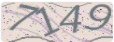

In [6]:
# 显示验证码图片
@multiple_trials()
def get_dynamic_code_img():
    img = find_element(hualala_driver, 'img', 'css', 'alt', '验证码')
    img.click()
    time.sleep(SECONDS['short'])
    return img.screenshot_as_png
    
display.Image(get_dynamic_code_img())

In [7]:
# 输入人肉识别二维码

@multiple_trials()
def enter_dynamic_code():
    dynamic_code = hualala_driver.find_element_by_name('dynamicCode')
    code = input('请输入图片验证码\n')
    
    dynamic_code.clear()
    dynamic_code.send_keys(code)
    
    login = find_element(hualala_driver, 'submit', property_val='登录')
    login.click()
    time.sleep(SECONDS['middle'])
    
enter_dynamic_code()

请输入图片验证码
7149


In [8]:
# 获取店铺信息

@multiple_trials()
def get_shop_info():
    hualala_driver.get(url)
    class_name = 'page-menu-title'
    find_element(hualala_driver, class_name, property_val='商户基本档').click()
    find_element(hualala_driver, class_name, property_val='店铺管理').click()
    find_element(hualala_driver, class_name, property_val='店铺信息').click()
    find_element(hualala_driver, 'button', 'css', property_val='导出到Excel').click()
    time.sleep(SECONDS['middle'])
    
get_shop_info()

In [9]:
# 集团菜品
@multiple_trials()
def get_master_commodity():
    hualala_driver.get(url)
    class_name = 'page-menu-title'
    
    find_element(hualala_driver, class_name, property_val='商户基本档').click()
    find_element(hualala_driver, class_name, property_val='集团菜谱').click()

    find_element(hualala_driver, class_name, property_val='菜品库').click()

    find_element(hualala_driver, 'button', 'css', property_val='更多操作').click()

    find_element(hualala_driver, 'ant-dropdown-menu-item', property_val='菜品导出').click()
    
    find_element(hualala_driver, 'ant-select', property_val='请选择品牌').click()
    
    find_element(hualala_driver, 'ant-select-dropdown-menu-item', 
                 property_val='满足盖饭').click()
    
    find_element(hualala_driver, 'button', 'css', property_val='导出菜品').click()
    time.sleep(SECONDS['middle'])
       
get_master_commodity()

In [10]:
# 获取门店菜品信息
@multiple_trials()
def get_shop_commodity():
    hualala_driver.get(url)
    class_name = 'page-menu-title'
    time.sleep(SECONDS['short'])
    find_element(hualala_driver, class_name, property_val='商户基本档').click()
    find_element(hualala_driver, class_name, property_val='集团菜谱').click()
    find_element(hualala_driver, class_name, property_val='门店菜谱').click()
    find_element(hualala_driver, class_name, property_val='门店菜品管理').click()
    time.sleep(SECONDS['middle'])

    find_element(hualala_driver, 'anticon-plus-circle-o').click()
    time.sleep(SECONDS['short'])
    rect = find_element(hualala_driver, 'ant-row-flex')
    filter_list = find_element(rect, 'filterList')

    for x in filter_list.find_elements_by_css_selector('label'):
        x.click()
        time.sleep(SECONDS['short'])

    result_list = find_element(rect, 'resultList')

    for x in get_elements(result_list, 'label', 'css'):
        if x.text == '全选':
            x.click()
            time.sleep(SECONDS['short'])

    find_element(hualala_driver, 'button', 'css', property_val='确定').click()
    find_element(hualala_driver, 'button', 'css', property_val='查询').click()

    find_element(hualala_driver, 'ant-pagination-item')
    
    find_element(hualala_driver, 'button', 'css', property_val='导出EXCEL').click()

    time.sleep(SECONDS['middle'])
    
get_shop_commodity()

wait 0 seconds
multiple_trials 1: get_element_map, (<selenium.webdriver.chrome.webdriver.WebDriver (session="75b139b444770674aa7cb0c34b28d96f")>, 'button', 'css', 'text'), {}

ERROR: Message: stale element reference: element is not attached to the page document
  (Session info: chrome=86.0.4240.30)


wait 1 seconds
multiple_trials 2: get_element_map, (<selenium.webdriver.chrome.webdriver.WebDriver (session="75b139b444770674aa7cb0c34b28d96f")>, 'button', 'css', 'text'), {}



In [11]:
# 进入供应链，导出品项管理

@multiple_trials()
def get_supply_chain_materials():
    hualala_driver.get(url)
    class_name = 'page-menu-title'
    find_element(hualala_driver, class_name, property_val='供应链').click()
    time.sleep(SECONDS['short'])

    find_element(hualala_driver, class_name, property_val='品项').click()
    find_element(hualala_driver, class_name, property_val='品项管理').click()
    time.sleep(SECONDS['short'])

    find_element(hualala_driver, 'button', 'css', property_val='更多').click()

    time.sleep(SECONDS['short'])
    find_element(hualala_driver, 'a', by='css', property_val='导出品项').click()
    time.sleep(SECONDS['short'])

In [12]:
# 进入供应链，导出供应商

@multiple_trials()
def get_supply_chain_supplier():

    hualala_driver.get(url)
    class_name = 'page-menu-title'
    find_element(hualala_driver, class_name, property_val='供应链').click()
    time.sleep(SECONDS['short'])

    find_element(hualala_driver, class_name, property_val='供应商').click()
    find_element(hualala_driver, class_name, property_val='供货商管理').click()
    time.sleep(SECONDS['short'])

    get_button_map(hualala_driver)['更多'].click()
    time.sleep(SECONDS['short'])
    find_element(hualala_driver, 'a', by='css', property_val='导出供应商').click()
    time.sleep(SECONDS['short'])

In [13]:
# 进入供应链，导出库存进出明细表

@multiple_trials()
def get_supply_chain_stock_change_log():
    hualala_driver.get(url)
    class_name = 'page-menu-title'
    find_element(hualala_driver, class_name, property_val='供应链').click()
    time.sleep(SECONDS['short'])
    find_element(hualala_driver, class_name, property_val='报表').click()
    find_element(hualala_driver, class_name, property_val='库存报表').click()
    find_element(hualala_driver, 'a', 'css', property_val='库存进出明细表').click()
    
    time.sleep(SECONDS['middle'])
    choose_date_range(hualala_driver)
    export_report(hualala_driver)
    
get_supply_chain_stock_change_log()

date map date range 2020-08-31 2020-10-11
exception 1
date map date range 2020-08-31 2020-10-11


In [14]:
# 供应商进货明细表

@multiple_trials()
def get_supply_chain_purchase_detail():
    hualala_driver.get(url)
    class_name = 'page-menu-title'
    find_element(hualala_driver, class_name, property_val='供应链').click()
    time.sleep(SECONDS['short'])
    find_element(hualala_driver, class_name, property_val='报表').click()
    time.sleep(SECONDS['short'])
    find_element(hualala_driver, class_name, property_val='库存报表').click()
    time.sleep(SECONDS['short'])

    find_element(hualala_driver, 'section', 'css', 'None', None) #
    section_map = OrderedDict()
    for section in hualala_driver.find_elements_by_css_selector('section'):
        text = section.find_element_by_css_selector('h4').text
        section_map[text] = section

    stock_map = get_element_map(section_map['供应商'], 'div', 'css')
    stock_map['供应商进货明细表'].click()

    time.sleep(SECONDS['short'])
    choose_date_range(hualala_driver)
    export_report(hualala_driver)


In [15]:
# 营销中心-礼品信息
def get_gift():
    hualala_driver.get(url)
    class_name = 'page-menu-title'
    find_element(hualala_driver, class_name, property_val='营销中心').click()
    time.sleep(SECONDS['short'])

    find_element(hualala_driver, class_name, property_val='礼品管理').click()
    find_element(hualala_driver, class_name, property_val='礼品信息').click()

    find_element(hualala_driver, 'button', 'css', property_val='查询').click()

    time.sleep(SECONDS['short'])
    html_file = 'tmp.html'
    with open(html_file, 'w') as f:
        f.write(hualala_driver.page_source)
    
    xs = pd.read_html(html_file)
    cols = xs[0].columns
    values = xs[1].values
    gift = pd.DataFrame(values, columns=cols)

    s = pd.Series({'filename': '营销中心-礼品信息_.xlsx', 
               'url': hualala_driver.current_url})
    other_downloads.append(s)
    gift.to_excel(s['filename'], index=False)
    
get_gift()

In [16]:
# 交易中心-账务主体
def get_account():
    hualala_driver.get(url)
    class_name = 'page-menu-title'
    find_element(hualala_driver, class_name, property_val='交易中心').click()
    time.sleep(SECONDS['short'])

    find_element(hualala_driver, class_name, property_val='账务主体').click()
    time.sleep(SECONDS['short'])
    get_element_map(hualala_driver,'p','css')['列表模式'].click()
    time.sleep(SECONDS['short'])
    html_file = 'tmp.html'
    with open(html_file, 'w') as f:
        f.write(hualala_driver.page_source)
    
    main_finance = pd.read_html(html_file)[0]
    main_finance.columns = [x[0] for x in main_finance.columns]

    s = pd.Series({'filename': '账务主体_.xlsx', 
               'url': hualala_driver.current_url})
    other_downloads.append(s)
    main_finance.to_excel(s['filename'], index=False)
    
get_account()

In [17]:
# 交易中心-支付流水查询
def get_pay_detail():
    hualala_driver.get(url)
    class_name = 'page-menu-title'
    find_element(hualala_driver, class_name, property_val='交易中心').click()
    time.sleep(SECONDS['short'])

    find_element(hualala_driver, class_name, property_val='支付流水查询').click()
    time.sleep(SECONDS['short'])
    get_button_map(hualala_driver)['指定日期'].click()
    choose_date_range(hualala_driver)
    export_report(hualala_driver)
    
get_pay_detail()

In [18]:
# 会员信息，会员卡信息 XXXX

def get_member_info():
    hualala_driver.get(url)
    class_name = 'page-menu-title'
    find_element(hualala_driver, class_name, property_val='会员中心').click()
    time.sleep(SECONDS['short'])

    find_element(hualala_driver, class_name, property_val='客户管理').click()
    find_element(hualala_driver, class_name, property_val='客户信息').click()
    time.sleep(SECONDS['short'])

    tab = find_element(hualala_driver, 'ant-tabs-nav', property_val='会员查询会员卡查询')

    get_element_map(tab, 'div', 'css')['会员查询'].click()
    time.sleep(SECONDS['short'])
    choose_date_range(hualala_driver)

    export_report(hualala_driver)
    time.sleep(SECONDS['short'])

    get_element_map(tab, 'div', 'css')['会员卡查询'].click()
    time.sleep(SECONDS['short'])
    choose_date_range(hualala_driver)
    export_report(hualala_driver)
    time.sleep(SECONDS['short'])
    
get_member_info()

In [19]:
# 清空下载清单
@multiple_trials()
def clear_download_list():
    hualala_driver.get(url)
    _ = find_element(hualala_driver, 'ant-menu-item', property_val='报表中心')
    report_center(hualala_driver)
    for n in range(10):
        print('n =', n)
        is_empty = download_list_action(hualala_driver, 'delete')
        if is_empty:
            break
    hualala_driver.close()
    time.sleep(SECONDS['short'])
    
clear_download_list()

title: report.hualala.com
n = 0
n = 1
n = 2


In [20]:
# 会员会员卡基础信息表

def get_member_card():
    report_map = report_center(hualala_driver)
    report_domain(hualala_driver, report_map, '会员营销报表', '会员会员卡基础信息表')
    choose_date_range(hualala_driver)
    export_report(hualala_driver)
    hualala_driver.close()
    time.sleep(SECONDS['short'])
    
get_member_card()

In [21]:
# 会员交易明细表

@multiple_trials()
def get_member_transaction():
    report_map = report_center(hualala_driver)
    report_domain(hualala_driver, report_map, '会员营销报表', '会员交易明细表') 
    choose_datetime_range(hualala_driver)
    export_report(hualala_driver)
    hualala_driver.close()
    time.sleep(SECONDS['short'])
    
get_member_transaction()

title: 哗啦啦报表中心


In [22]:
# 订单明细查询

def get_order():
    report_map = report_center(hualala_driver)
    report_domain(hualala_driver, report_map, '运营汇总报表', '订单明细查询')  
    choose_date_range(hualala_driver)
    export_report(hualala_driver)
    hualala_driver.close()
    time.sleep(SECONDS['short'])
    
get_order()

In [23]:
# 收银明细表

def get_pay_detail():
    report_map = report_center(hualala_driver)
    report_domain(hualala_driver, report_map, '运营汇总报表', '收银明细表')  
    choose_date_range(hualala_driver)
    export_report(hualala_driver)
    hualala_driver.close()
    time.sleep(SECONDS['short'])
    
get_pay_detail()

In [24]:
# 菜品销售明细表
@multiple_trials()
def get_order_item():
    report_map = report_center(hualala_driver)
    report_domain(hualala_driver, report_map, '菜品销售报表', '菜品销售明细表')  
    choose_date_range(hualala_driver)
    export_report(hualala_driver)
    hualala_driver.close()
    time.sleep(SECONDS['short'])
    
get_order_item()

title: 哗啦啦报表中心
date map date range 2020-08-31 2020-10-11
date map date range 2020-08-31 2020-10-11


In [25]:
# 下载

@multiple_trials()
def donwload_report():
    report_map = report_center(hualala_driver)
    download_df = get_download_items(hualala_driver)
    for download in download_df['download']:
        time.sleep(SECONDS['short'])
        download.click()

    return download_df

donwload_report()
time.sleep(SECONDS['middle'])

title: 哗啦啦报表中心


In [26]:

chrome_file_df = get_chrome_downloads(hualala_driver)
chrome_file_df

,filename,url
0,会员交易明细表 20200901--20200914.zip,https://report.hualala.com/report/download/dow...
1,菜品销售明细表(营业日) 20200901--20200914.zip,https://report.hualala.com/report/download/dow...
2,库存进出明细 20200901--20200914.xlsx,blob:https://shop.hualala.com/c85ab9e5-57e5-46...
3,wKgVbV9fhAboVaPcAAFUajFUKmA40.xlsx,http://res.hualala.com/group3/M03/D9/CC/wKgVbV...
4,wKgVe19fg-O43tA2AACu-Zl6kJY65.xlsx,http://res.hualala.com/group3/M01/DC/F5/wKgVe1...
5,wKgVbV9fg9CnAs38AABCJUVRE5041.xlsx,http://res.hualala.com/group3/M00/D9/CB/wKgVbV...


In [27]:
# 文件解压和重命名

def rename_filename(inner_file):
    ef = pd.ExcelFile(inner_file)
    sheet_name = ef.sheet_names[-1]
    
    filename, extension = os.path.splitext(inner_file)

    tmp = filename
    for c in string.punctuation:
        tmp = tmp.replace(c, '')
    if re.search('^[a-zA-Z0-9]+$', tmp) or not re.search(MONTH_ID, tmp):
        sheet_name = re.sub('[0-9]', '', sheet_name)
        filename = '{}_{}'.format(sheet_name, PT)
    else:
        filename = re.sub('\(.+?\)', '', filename)
        filename = re.sub('--\\d+', '', filename)
        filename = re.sub('\\s', '', filename)
        filename = re.sub('(\\d{6})\\d{2}', '\\1', filename)
        filename = re.sub('([^\\d]+)(\\d{6})\\.([a-z]*)$', '\\1_\\2.\\3', filename)
        
    filename += extension
    return filename

@multiple_trials()
def file_transform():
    file_df = pd.concat([chrome_file_df, pd.DataFrame(other_downloads)]).drop_duplicates()
    file_df = file_df.rename({'filename': 'raw_filename'}, axis=1)
    inner_files = []

    for _, s in file_df.iterrows():
        raw_file = s['raw_filename']
        if raw_file.endswith('zip'):
        
            zip_ref = zipfile.ZipFile(raw_file, 'r')
            inner_files.append(zip_ref.namelist())
            zip_ref.extractall('')
            zip_ref.close()
        else:
            inner_files.append([raw_file])
        
    file_df['inner_files'] = inner_files



    assert (file_df['inner_files'].apply(len) == 1).all()

    file_df['inner_file'] = file_df['inner_files'].apply(lambda x: x[0])
    file_df['filename'] = file_df['inner_file'].apply(rename_filename)
    file_df = file_df.sort_values('inner_file', ascending=False).groupby('filename').head(1)
    return file_df

file_df = file_transform()
file_df

,raw_filename,url,inner_files,inner_file,filename
1,菜品销售明细表(营业日) 20200901--20200914.zip,https://report.hualala.com/report/download/dow...,[菜品销售明细表(营业日) 20200901--20200914 (2020-09-14 2...,菜品销售明细表(营业日) 20200901--20200914 (2020-09-14 22...,菜品销售明细表202009.xlsx
2,库存进出明细 20200901--20200914.xlsx,blob:https://shop.hualala.com/c85ab9e5-57e5-46...,[库存进出明细 20200901--20200914.xlsx],库存进出明细 20200901--20200914.xlsx,库存进出明细202009.xlsx
0,会员交易明细表 20200901--20200914.zip,https://report.hualala.com/report/download/dow...,[会员交易明细表 20200901--20200914 (2020-09-14 22：56：...,会员交易明细表 20200901--20200914 (2020-09-14 22：56：5...,会员交易明细表202009.xlsx
4,wKgVe19fg-O43tA2AACu-Zl6kJY65.xlsx,http://res.hualala.com/group3/M01/DC/F5/wKgVe1...,[wKgVe19fg-O43tA2AACu-Zl6kJY65.xlsx],wKgVe19fg-O43tA2AACu-Zl6kJY65.xlsx,菜品规格与价格_20200914.xlsx
3,wKgVbV9fhAboVaPcAAFUajFUKmA40.xlsx,http://res.hualala.com/group3/M03/D9/CC/wKgVbV...,[wKgVbV9fhAboVaPcAAFUajFUKmA40.xlsx],wKgVbV9fhAboVaPcAAFUajFUKmA40.xlsx,远程管理门店菜品批量导出_20200914.xlsx
5,wKgVbV9fg9CnAs38AABCJUVRE5041.xlsx,http://res.hualala.com/group3/M00/D9/CB/wKgVbV...,[wKgVbV9fg9CnAs38AABCJUVRE5041.xlsx],wKgVbV9fg9CnAs38AABCJUVRE5041.xlsx,哗啦啦店铺信息批量导出_20200914.xlsx


In [28]:
for _, s in file_df.iterrows():
    copyfile(s['inner_file'], input_path(s['inner_file']))
    copyfile(s['inner_file'], output_path(s['filename']))

In [31]:
file_patterns = [
    '菜品规格与价格_*.xlsx',
    '远程管理门店菜品批量导出_*.xlsx',
    '哗啦啦店铺信息批量导出_*.xlsx',
    '会员交易明细表??????.xlsx',
    '菜品销售明细表??????.xlsx',
    '库存进出明细??????.xlsx'
]

for file_pattern in file_patterns:
    print(file_pattern, '-> ', end='')
    filenames = glob.glob(output_path(file_pattern))
    filenames = [os.path.basename(filename) for filename in filenames]
    
    check_ok = False
    for actual_file in filenames:
        if actual_file in file_df['filename'].values:
            print(actual_file)
            check_ok = True
            break
    assert check_ok

菜品规格与价格_*.xlsx -> 菜品规格与价格_20200914.xlsx
远程管理门店菜品批量导出_*.xlsx -> 远程管理门店菜品批量导出_20200914.xlsx
哗啦啦店铺信息批量导出_*.xlsx -> 哗啦啦店铺信息批量导出_20200914.xlsx
会员交易明细表??????.xlsx -> 会员交易明细表202009.xlsx
菜品销售明细表??????.xlsx -> 菜品销售明细表202009.xlsx
库存进出明细??????.xlsx -> 库存进出明细202009.xlsx


In [32]:
#退出爬虫
hualala_driver.quit()

# 删除下载文件夹中文件
for _, s in file_df.iterrows():
    os.remove(s['inner_file'])
    if s['raw_filename'] != s['inner_file']:
        os.remove(s['raw_filename'])

In [33]:
# 统计花费时间
run_time_map['end_time'] = time.time()
run_time_map['total_time'] = round(
    run_time_map['end_time'] - run_time_map['start_time'],
    1)

print('total time: {total_time} seconds'.format(**run_time_map))

total time: 392.4 seconds
